# Computer Vision - Maman 1
imports

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import grp

Constants

In [2]:
MEAN = 10
SD = 5
SIZE = (100, 100)

Helper Functions

In [3]:
def ranged_gausian(matrix, mean, scale, size, min_value, max_value):
    return min_value + (max_value - min_value) * (matrix - matrix.min()) / (matrix.max() - matrix.min())


### Question 1

In [4]:
matrix = np.array(np.random.normal(MEAN, SD, SIZE))

#### <ins>Q1 a </ins>

In [5]:
output_matrix = ranged_gausian(matrix, MEAN, SD, SIZE, min_value=0, max_value=255)
# print(matrix)

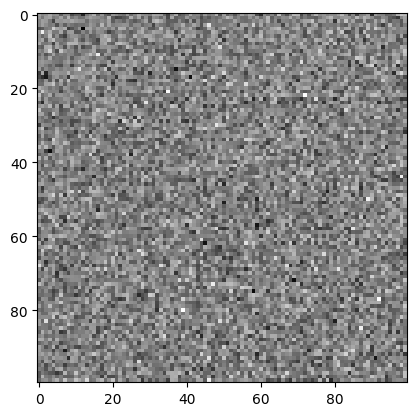

In [6]:
output = output_matrix.astype(np.uint8)
plt.imshow(output, cmap='gray')

#### <ins>Q1 b </ins>

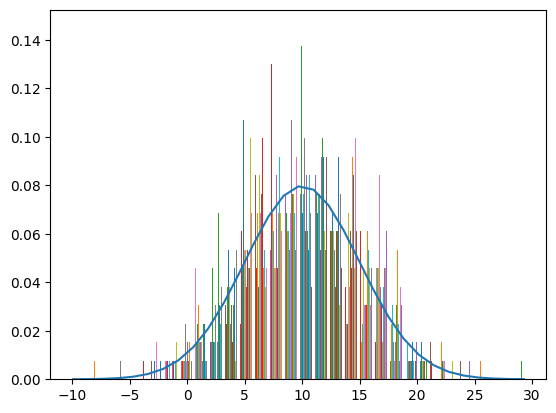

In [7]:
n, bins, ignored = plt.hist(matrix, bins=30, density=True)
# draw function
plt.plot(bins, np.exp(-pow(bins - MEAN, 2) / (2 * pow(SD, 2))) / (SD * np.sqrt(2 * np.pi)))
plt.show()

#### <ins>Q1 c </ins>

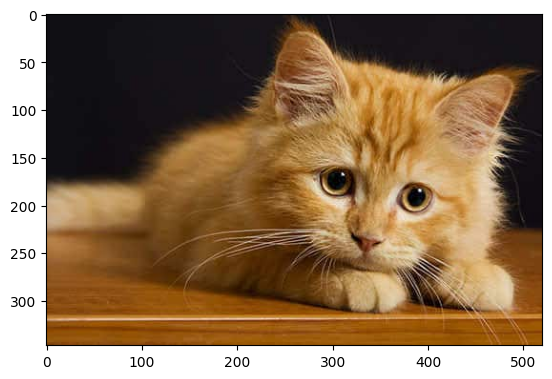

In [8]:
# path to input image specified and
# image is loaded with imread command
file_name = 'image.JPG'
image = cv2.imread(file_name, cv2.IMREAD_UNCHANGED)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

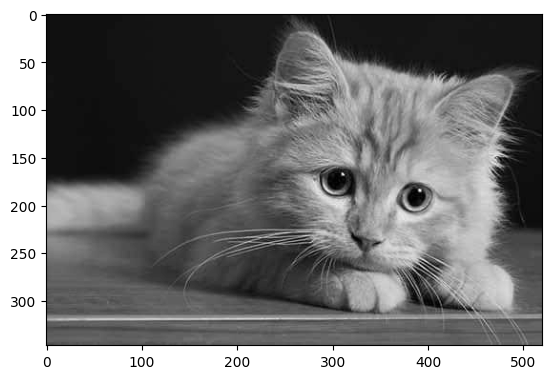

In [9]:
# convert the input image into
# grayscale color space
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image, cmap="gray")

#### <ins>Q1 d </ins>

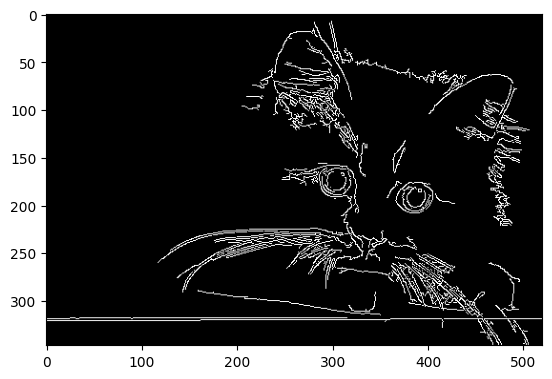

In [10]:
plt.imshow(cv2.Canny(image, 100, 350), cmap="gray")

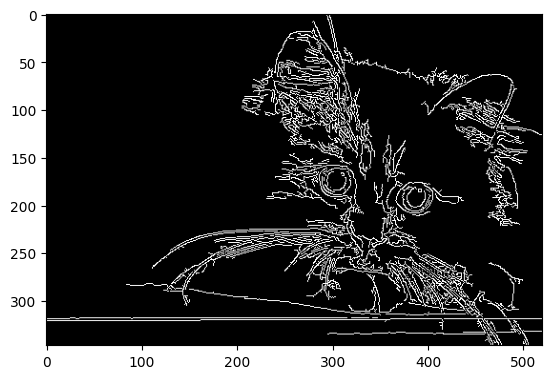

In [11]:
plt.imshow(cv2.Canny(image, 50, 300), cmap="gray")

#### <ins>Q1 E </ins>

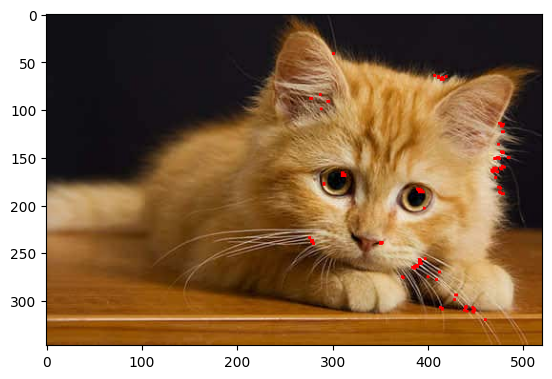

In [12]:
def add_harris_points(image, harris_param):
    # modify the data type
    # setting to 32-bit floating point
    operatedImage = np.float32(gray_image)
    
    # apply the cv2.cornerHarris method
    # to detect the corners with appropriate
    # values as input parameters
    dest = cv2.cornerHarris(operatedImage, 2, 3, harris_param)
    
    # Results are marked through the dilated corners
    dest = cv2.dilate(dest, None)
    # Reverting back to the original image,
    # with optimal threshold value
    image[dest > 0.01 * dest.max()]=[0, 0, 255]
    
    # the window showing output image with corners
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

add_harris_points(image, 0.08)

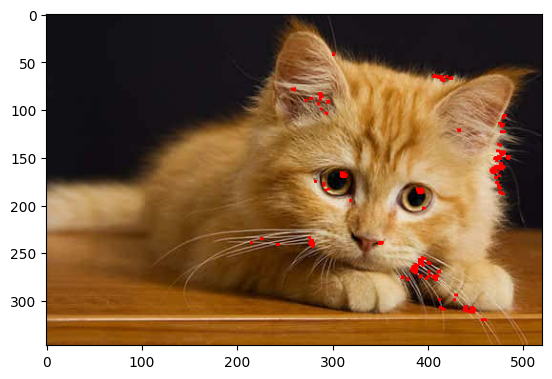

In [13]:
add_harris_points(image, 0.01)

### Question 2

The function we got as data:

In [14]:
import cv2
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
def log_filt(ksize, sig):
    std2 = float( sig**2 )
    x = np.arange( -(ksize-1)/2, (ksize-1)/2+1, 1)
    y = np.arange( -(ksize-1)/2, (ksize-1)/2+1, 1)
    X, Y = np.meshgrid(x, y)
    arg = -(X*X + Y*Y)/(2*std2);
    
    h = np.exp(arg);
    eps = sys.float_info.epsilon
    h[h < eps*np.max(h)] = 0;
    
    sumh = np.sum(h)
    if sumh != 0:
       h  = h/sumh
       
       # now calculate Laplacian     
    h1 = h*(X*X + Y*Y - 2*std2)/(std2**2);
    h = h1 - np.sum(h1)/(ksize*ksize) # make the filter sum to zero
  
    return h

Implementation:

In [251]:
k = 2 ** 0.25
sigma = 2
n = 15
file_name_butterfly = 'butterfly.jpg'
file_name_einstein = 'einstein.jpg'
file_name_fishes = 'fishes.jpg'
file_name_sunflowers = 'sunflowers.jpg'

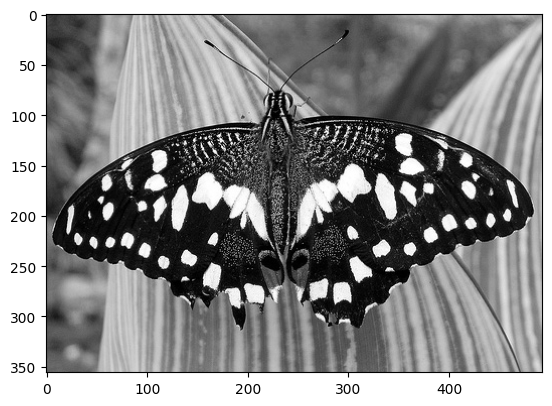

In [252]:
def load_image(file_name: str):
    image_color = cv2.imread(file_name, cv2.IMREAD_UNCHANGED)
    image_color = cv2.imread(file_name, cv2.IMREAD_UNCHANGED)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image_color, image_gray

image_color, image_gray = load_image(file_name_butterfly)
image_gray = image_gray/255.0  #image normalization
plt.imshow(image_gray, cmap="gray")

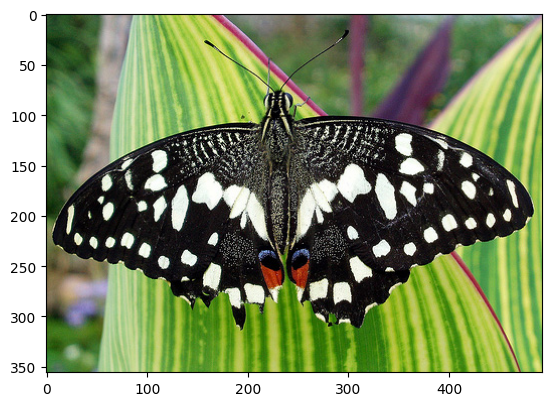

In [253]:
plt.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))

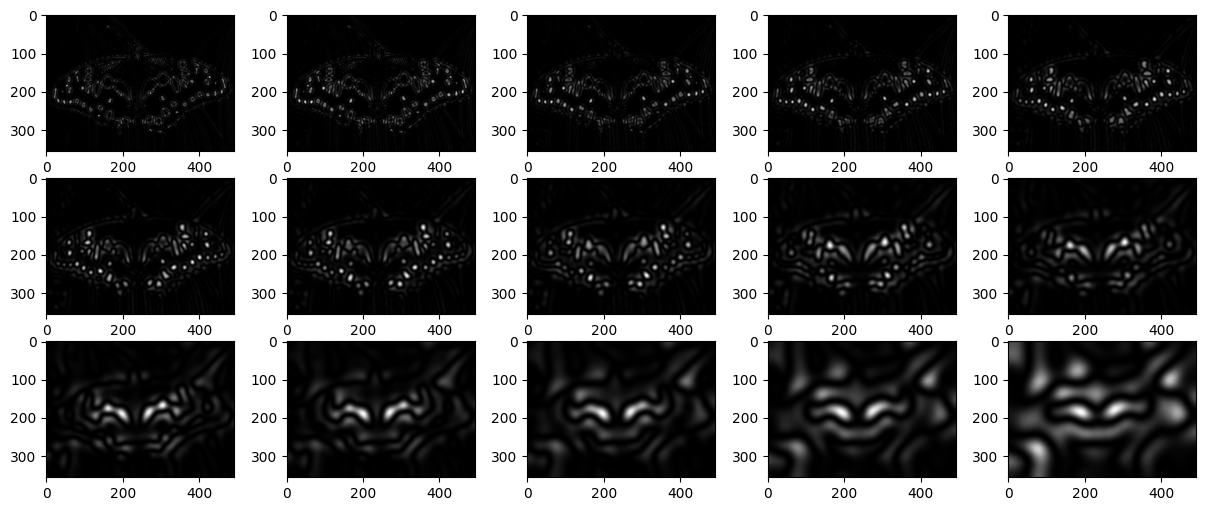

In [254]:
def LoG_pyramid(img, n, k, sigma):
    log_images = [] #to store responses
    curr_sigam = sigma
    for i in range(0, n):
        curr_sigam *= k #sigma 
        filter_size = 2 * np.ceil(3 * curr_sigam) + 1
        filter_log = log_filt(filter_size, curr_sigam) * (curr_sigam ** 2) #filter generation
        image = cv2.filter2D(img,cv2.CV_64F,filter_log)  # convolving image
        log_images.append(image)
    log_image_np = np.array([i for i in log_images]) # storing the #in numpy array
    return log_image_np

fig = plt.figure(figsize=(15, 6))
log_image_np = LoG_pyramid(image_gray, n, k, sigma)
for i in range(1, n+1):
    log_image_np[i-1] = np.square(log_image_np[i-1])
    #print(log_image_np[i-1].shape)
    fig.add_subplot(3, 5, i)
    plt.imshow(log_image_np[i-1], cmap="gray")
plt.show(block=True)

In [255]:
def maximaDetection(img, log_pyramid, window, depth, sigma, k, threshold=0.03):
    half_window = window // 2
    half_depth = depth // 2
    row, col = img.shape
    scales = log_pyramid.shape[0]
    blobs = []
    log_pyramid = np.pad(log_pyramid, [(half_depth,half_depth),(half_window,half_window),(half_window,half_window)], mode='constant',constant_values=0)
    #for s in range(half_depth, scales+half_depth):
    for i in range(half_window, row+half_window):
        for j in range(half_window, col+half_window):
            slice_pyramid = log_pyramid[:, i-half_window:i+half_window+1,j-half_window:j+half_window+1]
            center = slice_pyramid[:, half_window, half_window]
            result = np.amax(slice_pyramid)
            if result in center:
                if result>=threshold:
                    z, x, y = np.unravel_index(slice_pyramid.argmax(), slice_pyramid.shape)
                    blob_x = x+i-half_window-1
                    
                    blobs.append((blob_x, y+j-half_window-1, sigma*k**(z)))
    return blobs
blobs = maximaDetection(image_gray,log_image_np, 3, 3,sigma, k)

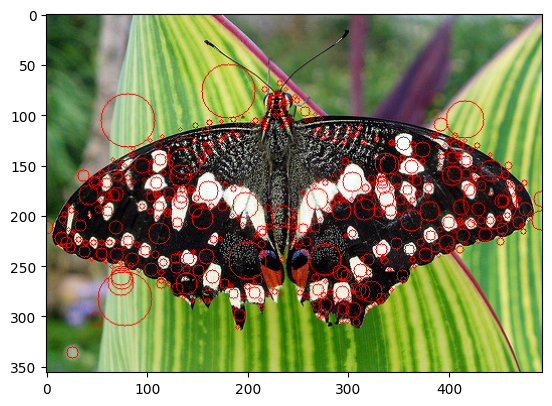

In [256]:
def draw_blobs(image, blobs):
    out_image = image.copy()
    for blob in blobs:
        #print(blob)
        radius = np.round(blob[2]).astype("int")
        cv2.circle(out_image, (blob[1],blob[0]), abs(radius), (0,0,255), 1)
    return out_image
out_image = draw_blobs(image_color, blobs)
plt.imshow(cv2.cvtColor(out_image, cv2.COLOR_BGR2RGB))

In [257]:
def detect_blobs(filename):
    image_color, image_gray = load_image(file_name_butterfly)
    log_image_np = LoG_pyramid(image_gray, n, k, sigma)
    blobs = maximaDetection(image_gray,log_image_np, 3, 3,sigma, k)
    out_image = draw_blobs(image_color, blobs)
    plt.imshow(cv2.cvtColor(out_image, cv2.COLOR_BGR2RGB))